# MNIST Scratch

MNIST: Completely from scratch, only using Torch primitives.

# Dataset

In [13]:
import torch
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
train_image_zero, train_target_zero = trainset[0]

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:1], nrow=8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


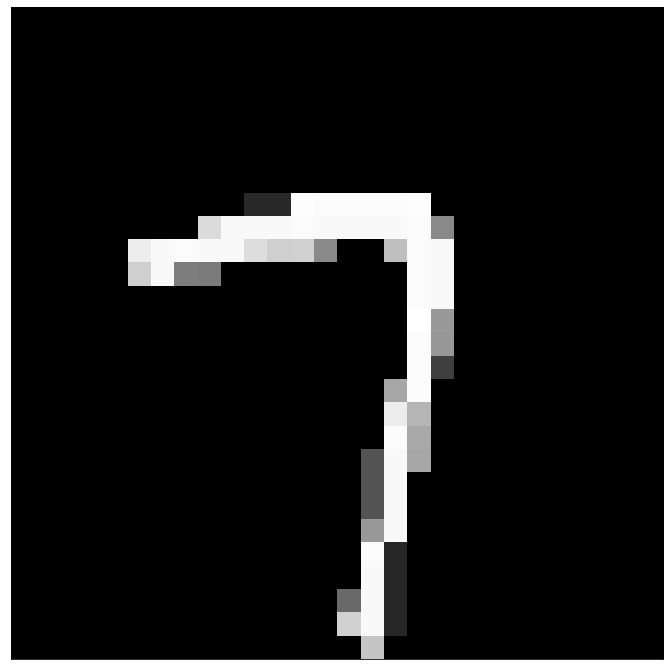

In [14]:
show_batch(trainloader)

# Model

In [197]:
import numpy as np

def cross_entropy(y_pred, y_true):
    n_samples = y_pred.shape[0]
    y_prob = softmax(y_pred)
    y_correct_probs = y_prob[range(n_samples), y_true]
    return -torch.mean(torch.log(y_correct_probs))
    
def delta_cross_entropy(y_pred, y_true):
    y_pred_copy = y_pred.clone()
    n_samples = y_pred_copy.shape[0]
    y_pred_copy[range(n_samples), y_true] -= 1
    return y_pred_copy / n_samples

def relu(x):
    return torch.where(x > 0, x, torch.zeros_like(x))

def relu_prime(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

def softmax(x):
    exps = torch.exp(x - torch.max(x, axis=1, keepdims=True).values)
    return exps / torch.sum(exps, axis=1, keepdims=True)

class Linear(object):
    def __init__(self, in_dim: int, out_dim: int, debug: bool=False):
        self.debug = debug
        self.w  = torch.randn(in_dim, out_dim) * torch.sqrt(torch.tensor(2. / (in_dim + out_dim)))
        self.b  = torch.zeros(out_dim)
        self.dw = None
        self.db = None
        self.input = None
    def __call__(self, x: torch.tensor) -> torch.tensor:
        return self.forward(x)
    def forward(self, x: torch.tensor) -> torch.tensor:
        self.input = x
        return torch.mm(x, self.w) + self.b
    def backward(self, d_out):
        self.dw = torch.mm(self.input.T, d_out)
        self.db = torch.sum(d_out, axis=0)
        d_input = torch.mm(d_out, self.w.T)
        return d_input
    
class MLP(object):
    def __init__(self, debug: bool=False):
        self.debug = debug
        self.fc1 = Linear(784, 512, self.debug)
        self.fc2 = Linear(512, 10, self.debug)
    def __call__(self, x: torch.tensor) -> torch.tensor:
        return self.forward(x)
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.fc1(x)
        x = relu(x)
        x = self.fc2(x)
        x = softmax(x)
        return x
    def backward(self, d_out):
        d_out = self.fc2.backward(d_out)
        d_out = d_out * relu_prime(self.fc1.forward(self.fc1.input))
        d_out = self.fc1.backward(d_out)
        return d_out

# Forward Pass - Single

In [193]:
from einops import rearrange
import torch.nn.functional as F

for img, lbl in trainloader:
    img  = rearrange(img, "b c w h -> (b c) (w h)")
    print(img.shape)
    pred = model(img)
    lbl_onehot = F.one_hot(lbl, num_classes=10)
    print("lbl_onehot:", lbl, lbl_onehot)
    break

print("pred:", pred)

torch.Size([1, 784])


TypeError: 'MLP' object is not callable

# Backpropagation - Multi (Set Epochs := 1, for Single)

In [ ]:
model = MLP() #] debug=False)

learning_rate = 1e-3

losses = []
losses_s = []

for epoch in range(1):
    for i, (img, lbl) in enumerate(trainloader):
        with torch.no_grad():
            if i % 1 == 0 and losses:
                cur_loss = np.mean(np.array(losses))
                print(f"Epoch: {epoch} Item: {i} Loss: {cur_loss}")
                losses_s.append(cur_loss)

            img  = rearrange(img, "b c w h -> (b c) (w h)")
            # print("img.shape:", img.shape)
            # Forward, Loss
            pred = model.forward(img)
            loss = cross_entropy(pred, lbl)
            losses.append(loss.item())

            # Backward
            # print("pred, lbl:", pred, lbl)
            d_loss = delta_cross_entropy(pred, lbl)
            model.backward(d_loss) # calculate deltas

            # Update weights
            model.fc1.w -= learning_rate * model.fc1.dw
            model.fc1.b -= learning_rate * model.fc1.db
            model.fc2.w -= learning_rate * model.fc2.dw
            model.fc2.b -= learning_rate * model.fc2.db

# Plot Losses

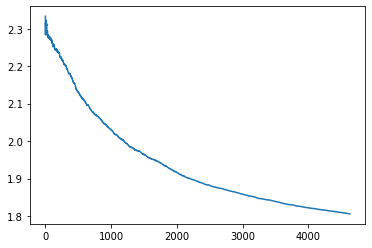

In [221]:
import matplotlib.pyplot as plt
plt.plot(losses_s)

# Test

In [222]:
correct_count, all_count = 0, 0
for images,labels in testloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.827
